## Import Package

In [1]:
%tensorflow_version 2.x

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
import shutil
import zipfile
import random

import tensorflow as tf


TensorFlow 2.x selected.


## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root_dir = '/content/drive/Shared drives/scsa_2019_a/Project/iu.zip'

# data_list = pathlib.Path('/content/drive/Shared drives/scsa_2019_a/Project/dataset_test').glob('*')
zip_ref = zipfile.ZipFile(root_dir, 'r')
zip_ref.extractall("/")
zip_ref.close()

In [9]:
data_dir = pathlib.Path('/iu_folder')
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

874


In [10]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
# CLASS_NAMES = ['iu']
print(CLASS_NAMES)

['iu']


In [0]:
# image generator for unziped directory 
image_generator = (
    tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255))

In [12]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 874

data_gen = image_generator.flow_from_directory(
                      directory=str(data_dir),
                      batch_size=BATCH_SIZE,
                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                      classes = list(CLASS_NAMES)    
                      )


Found 874 images belonging to 1 classes.


In [0]:
x_dat, l_batch = next(data_gen)

In [14]:
x_dat.shape

(874, 128, 128, 3)

## Model

In [0]:
from tensorflow import keras
from tensorflow.keras import layers, datasets, models, utils

from tensorflow.keras import backend as K

In [0]:
# encoder
img_shape = (128, 128, 3)
latent_dim = 2

input_layer = layers.Input(shape=img_shape)

e = layers.Conv2D(32, 3, padding='same', activation='relu')(input_layer)
e = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(e)
e = layers.Conv2D(128, 3, padding='same', activation='relu')(e)
e = layers.Conv2D(256, 3, padding='same', activation='relu')(e) #(14,14,64)

shape_before_flattening = K.int_shape(e)
flat = layers.Flatten()(e) #(12544)<-(14,14,64)
x = layers.Dense(32, activation='relu')(flat)

# 가정한 확률분포의 모수
z_mean = layers.Dense(latent_dim)(x)    #(2)<-(32) 
z_log_var = layers.Dense(latent_dim)(x) #(2)<-(32) 

In [0]:
def sampling(args):
  # Reparameterization trick for back-propagation
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), #(bs,2)
                            mean=0., stddev=1)
  return z_mean + K.exp(z_log_var) * epsilon # exp(ln(variance=sig^2))=sig^2

z = layers.Lambda(sampling)([z_mean, z_log_var]) # z(2):latent variable(샘플링된 값)

In [18]:
# Decoder
decoder_input = layers.Input(K.int_shape(z)[1:])        #Input의 shape지정:(2)

x = layers.Dense(np.prod(shape_before_flattening[1:]),  #.Dense((14x14x64=12544), 
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)      #.Reshape(14,14,64)(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu',
                           strides=(2, 2))(x)           # (28,28,32) 
x = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x) #(28,28,1)<-

decoder = models.Model(decoder_input, x)
z_decoded = decoder(z)   # Decoded Image <- decoder(sampled z)
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1048576)           3145728   
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 32)      73760     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 3)       867       
Total params: 3,220,355
Trainable params: 3,220,355
Non-trainable params: 0
_________________________________________________________________


In [0]:
class CustomVariationalLayer(layers.Layer):
  # loss function
  def vae_loss(self, x, z_decoded): 

    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    # 여기에서 - 가 곱해져 있다.
    cross_entropy_loss = keras.metrics.binary_crossentropy(x, z_decoded)

    kl_loss = -5e-4 * K.mean(1 + z_log_var -
                              K.square(z_mean) - K.exp(z_log_var), axis=-1)

    return K.mean(cross_entropy_loss + kl_loss)

  def call(self, inputs): # input을 받아서 loss계산후 저장하고, input[0]는 return
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

y = CustomVariationalLayer()([input_layer, z_decoded])

In [20]:
# model
vae = models.Model(input_layer, y)
vae.compile(
  optimizer='adam',loss=None,
  experimental_run_tf_function=False # for tf 2
  )   
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  73856       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [21]:
%%time
vae.fit(x=x_dat, y=None, shuffle=True, epochs=1800,
        batch_size=64, verbose=1)
vae.save_weights('./vae_iu.h5', overwrite=True)

Train on 874 samples
Epoch 1/1800
874/874 [==============================] - 10s 12ms/sample - loss: 0.7382
Epoch 2/1800
874/874 [==============================] - 4s 4ms/sample - loss: 0.6858
Epoch 3/1800
874/874 [==============================] - 4s 4ms/sample - loss: 0.6799
Epoch 4/1800
874/874 [==============================] - 4s 4ms/sample - loss: 0.6689
Epoch 5/1800
874/874 [==============================] - 4s 4ms/sample - loss: 0.6486
Epoch 6/1800
874/874 [==============================] - 4s 4ms/sample - loss: 0.6343
Epoch 7/1800
874/874 [==============================] - 4s 4ms/sample - loss: 0.6280
Epoch 8/1800
874/874 [==============================] - 4s 4ms/sample - loss: 0.6190
Epoch 9/1800
874/874 [==============================] - 4s 4ms/sample - loss: 0.6090
Epoch 10/1800
874/874 [==============================] - 4s 4ms/sample - loss: 0.6044
Epoch 11/1800
874/874 [==============================] - 4s 4ms/sample - loss: 0.5996
Epoch 12/1800
874/874 [=================

## Plot

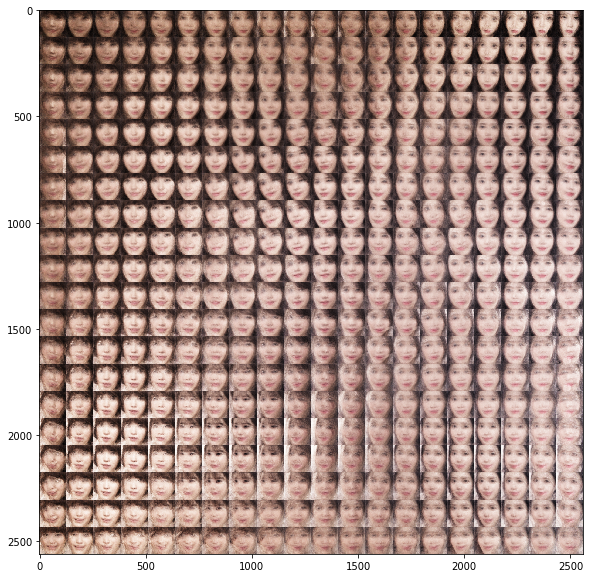

In [22]:
# 20
import matplotlib.pyplot as plt
from scipy.stats import norm

batch_size = 1
n = 20
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n, 3))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size, 3)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

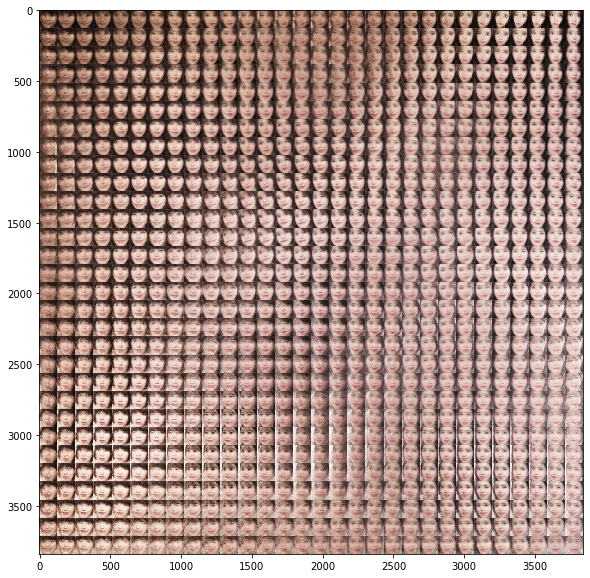

In [23]:
# 30
import matplotlib.pyplot as plt
from scipy.stats import norm

batch_size = 1
n = 30
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n, 3))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size, 3)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

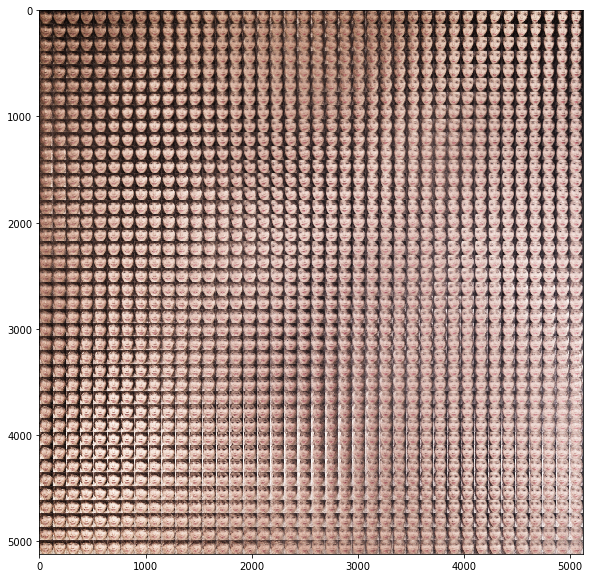

In [24]:
# 40
import matplotlib.pyplot as plt
from scipy.stats import norm

batch_size = 1
n = 40
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n, 3))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size, 3)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

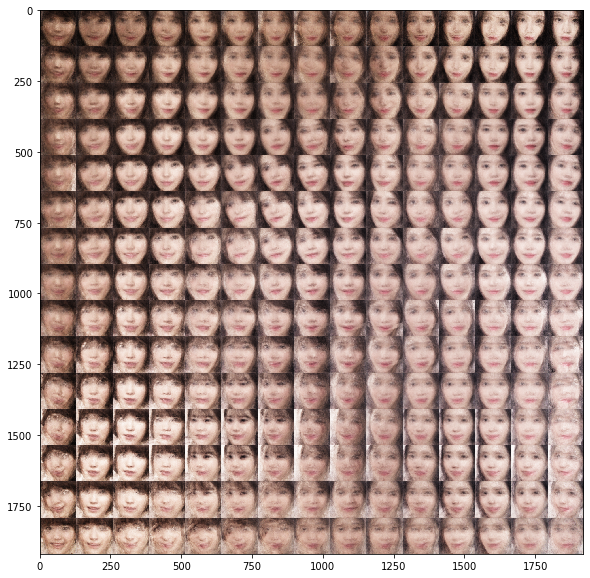

In [25]:
# 15
import matplotlib.pyplot as plt
from scipy.stats import norm

batch_size = 1
n = 15
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n, 3))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size, 3)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()